# Comparing activation functions

Units in neural networks typically compute linear operations. Thus, for the network to learn any nonlinear function or decision boundary, these operations must be fed through nonlinear functions. These functions are called **activation functions**, by analogy with biological neurons: we interpret the output of an activation function as the strength of the signal each neuron provides to the next neuron in the network.

In this notebook, we compare a few different activation functions available in PyTorch with a simple experiment. We build several models for solving a binary classification problem. All models have the same basic architecture, differing only in the activation function.

## Imports and basic definitions

In [1]:
# Imports
import torch
from torch import nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
from typing import Optional, List, Tuple

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
### Basic definitions
# Define accuracy (metric for evaluation)
def accuracy_fn(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred))
  return acc

In [55]:
# Define base class for models
class BaseModel(nn.Module):
  """General model for solving classification problems."""
  def __init__(self,
               activation,
               loss_fn=nn.BCEWithLogitsLoss(),
               optimizer=torch.optim.SGD,
               lr: float = 0.1):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.activation = activation
    self.layers = nn.Sequential(self.layer_1, self.activation,
                                self.layer_2, self.activation,
                                self.layer_3)
    self.loss_fn = loss_fn
    self.lr = lr
    self.optimizer = optimizer(self.parameters(), self.lr)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layers(x)

  def train_step(
      self, X_train: torch.Tensor, y_train: torch.Tensor
      ) -> Tuple[torch.Tensor, torch.Tensor]:
    """One epoch of training loop. Return training loss and training accuracy."""
    self.train()
    y_logits = self(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    loss = self.loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_preds, y_train)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    return loss, acc

  def eval_step(
      self, X_test: torch.Tensor, y_test: torch.Tensor
      ) -> Tuple[torch.Tensor, torch.Tensor]:
    """Evaluate on test data. Return testing loss and testing accuracy."""
    self.eval()
    with torch.inference_mode():
      y_logits = self(X_test).squeeze()
      y_preds = torch.round(torch.sigmoid(y_logits))
      loss = self.loss_fn(y_logits, y_test)
      acc = accuracy_fn(y_preds, y_test)
    return loss, acc

  def train_and_eval_loop(
      self,
      epochs: int,
      X_train: torch.Tensor,
      y_train: torch.Tensor,
      X_test: Optional[torch.Tensor] = None,
      y_test: Optional[torch.Tensor] = None,
      print_every: Optional[int] = None
      ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """Train and evaluate for a given number of epochs. Evaluation will be
    skipped if X_test is None. Optionally print loss and accuracy periodically
    (with period given by print_every). Return history of loss and accuracy
    on both training and test data.
    """
    train_loss_hist = []
    train_acc_hist = []
    test_loss_hist = []
    test_acc_hist = []
    for epoch in range(epochs):
      train_loss, train_acc = self.train_step(X_train, y_train)
      train_loss_hist.append(train_loss.item())
      train_acc_hist.append(train_acc)
      if X_test is not None:
        test_loss, test_acc = self.eval_step(X_test, y_test)
        test_loss_hist.append(test_loss.item())
        test_acc_hist.append(test_acc)
      if print_every is not None and epoch % print_every == 0:
        status_str = (f"Epoch {epoch}\t| Training loss: {train_loss:0.4f}\t" +
                      f"| Training accuracy: {train_acc*100:0.2f}%")
        if X_test is not None:
          status_str += (f"\t| Test loss: {test_loss:0.4f}\t" +
                          f"| Test accuracy: {test_acc*100:0.2f}%")
        print(status_str)
    return (train_loss_hist, train_acc_hist, test_loss_hist, test_acc_hist)




In [38]:
# Plotting utilities
def plot_decision_boundary(model: BaseModel, X: torch.Tensor, y: torch.tensor,
                           ax: plt.Axes, model_name: Optional[str] = None):
  """Plot decision boundary generated by model."""
  # Move everything to CPU
  model.to("cpu")
  X, y = X.to("cpu"), y.to("cpu")

  # Setup prediction boundaries and grid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

  # Make features
  X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

  # Make predictions
  model.eval()
  with torch.inference_mode():
      y_logits = model(X_to_pred_on)

  # Test for multi-class or binary and adjust logits to prediction labels
  if len(torch.unique(y)) > 2:
      y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # multi-class
  else:
      y_pred = torch.round(torch.sigmoid(y_logits))  # binary

  # Reshape preds and plot
  y_pred = y_pred.reshape(xx.shape).detach().numpy()
  out = ax.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  ax.set_xlim(xx.min(), xx.max())
  ax.set_ylim(yy.min(), yy.max())
  if model_name:
    ax.set_title(f"Decision boundary: {model_name}")
  return out

def plot_loss_and_acc(hists, axs: Tuple[plt.Axes, plt.Axes],
                      model_name: Optional[str]=None):
  """axs a pair of Axis objects. Plot loss histories on the first Axis, ans
  accuracy histories on the second Axis.
  """
  epochs = range(len(hists[0]))
  out = [0, 0]
  out[0] = axs[0].plot(epochs, hists[0], color="turquoise", label="Training loss")
  out[1] = axs[1].plot(epochs, hists[1], color="orchid", label="Training accuracy")
  if len(hists) == 4:
    axs[0].plot(epochs, hists[2], color="goldenrod", label="Test loss")
    axs[1].plot(epochs, hists[3], color="orange", label="Test accuracy")
  if model_name:
    axs[0].set_title(f"Loss: {model_name}")
    axs[1].set_title(f"Accuracy: {model_name}")
  else:
    axs[0].set_title("Loss")
    axs[1].set_title("Accuracy")
  axs[0].legend()
  axs[1].legend()
  return out

## Data generation
We'll use a binary-labelled dataset with two concentric circles. This is a simple example where the models have to learn a nonlinear decision boundary.

[[ 0.31372949 -0.69073925]
 [-0.95422563 -0.16473988]
 [-0.0263976   0.79221825]
 [-0.59515748 -0.79748638]
 [-1.03905294  0.08825166]] [1 0 1 0 0]
(1000, 2) (1000,)


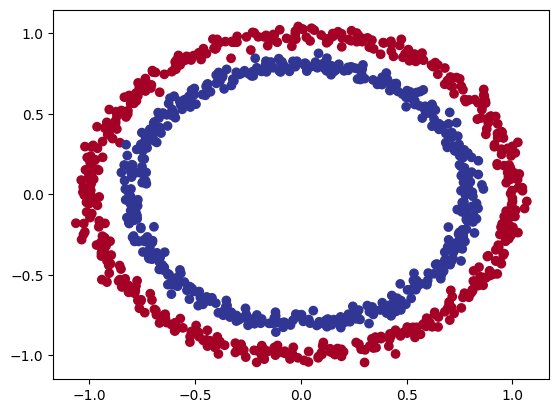

In [5]:
# Generate data
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=8)
print(X[:5], y[:5])
print(X.shape, y.shape)
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [6]:
# turn data to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print(X[:5], y[:5])


tensor([[ 0.3137, -0.6907],
        [-0.9542, -0.1647],
        [-0.0264,  0.7922],
        [-0.5952, -0.7975],
        [-1.0391,  0.0883]]) tensor([1., 0., 1., 0., 0.])


In [7]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Move to GPU if we have it
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

torch.Size([800, 2]) torch.Size([800]) torch.Size([200, 2]) torch.Size([200])


## Comparison of activation functions

Now let's compare different activation functions! First, we define several different models.

In [51]:
# Now let's compare activation functions!
models = {
    "ReLU": BaseModel(activation=nn.ReLU()),
    "Leaky ReLU": BaseModel(activation=nn.LeakyReLU()),
    "Sigmoid": BaseModel(activation=nn.Sigmoid()),
    "Tanh": BaseModel(activation=nn.Tanh()),
    "ELU": BaseModel(activation=nn.ELU()),
    "Hard Swish": BaseModel(activation=nn.Hardswish())
}
for model in models.values():
  model.to(device)

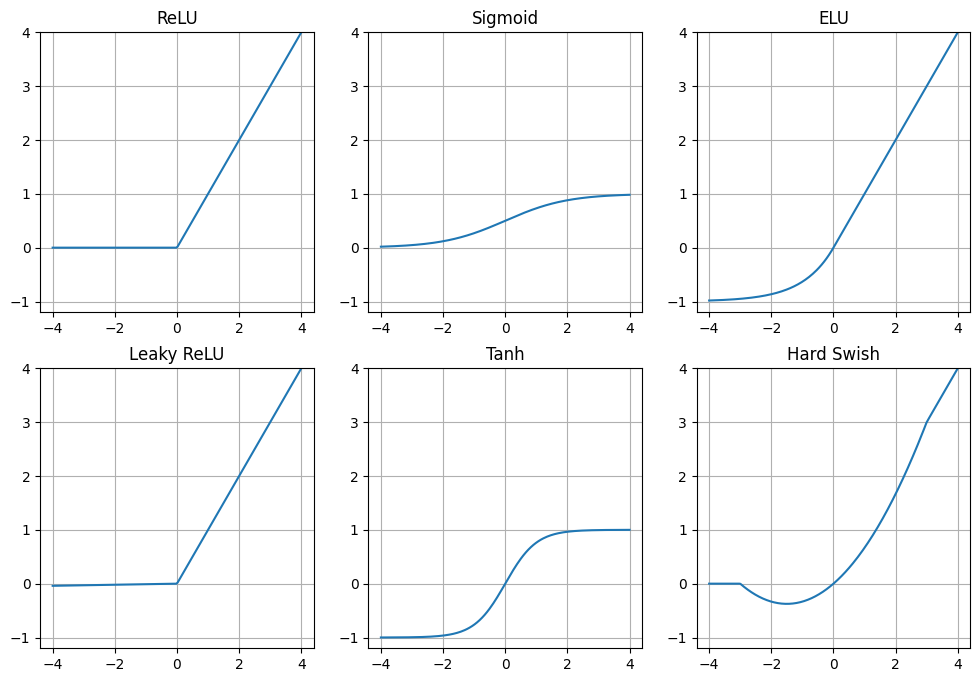

In [52]:
# Let's plot all the activation functions
fig, axs = plt.subplots(2, 3, figsize=(12,8))
input = np.linspace(-4, 4, 200)
for i, model_name in enumerate(models.keys()):
  ax = axs[i%2][i//2]
  output = models[model_name].activation(torch.from_numpy(input)).numpy()
  ax.plot(input, output)
  ax.set_title(model_name)
  ax.set_ylim(-1.2, 4)
  ax.grid(True)

What do these functions have in common? How do they differ?

The ReLU, Leaky ReLU, ELU, and Hard Swish functions all have the same basic shape: they grow linearly and unboundedly for large positive values of $x$, and are essentially constant for large negative values of $x$. The ReLU and Hard Swish functions are 0 for large negative values of $x$, while ELU converges asymptotically to $-1$, and Leaky ReLU is linear with a very small slope (hard to see on the above plot). Around 0, the functions interpolate differently between the two behaviors, with ReLU and Leaky ReLU simply moving instantaneously between two different linear behaviors, while ELU uses an exponential interpolation and Hard Swish as a quadratic one.

The other class of activation function, including Tanh and Sigmoid, converges to an asymptote for both large negative and large positive values of $x$. The Sigmoid function goes to 0 as $x \to -\infty$ and to 1 as $x \to +\infty$, while Tanh goes to -1 as $x \to -\infty$ and to 1 as $x \to +\infty$. Additionally, the Tanh function has a much steeper slope around $x=0$ than the Sigmoid function.

In [53]:
# Train models
epochs = 2000
hist_dict = {name: [] for name in models.keys()}
for name in models.keys():
  hist_dict[name] = models[name].train_and_eval_loop(epochs, X_train, y_train,
                                                     X_test, y_test)


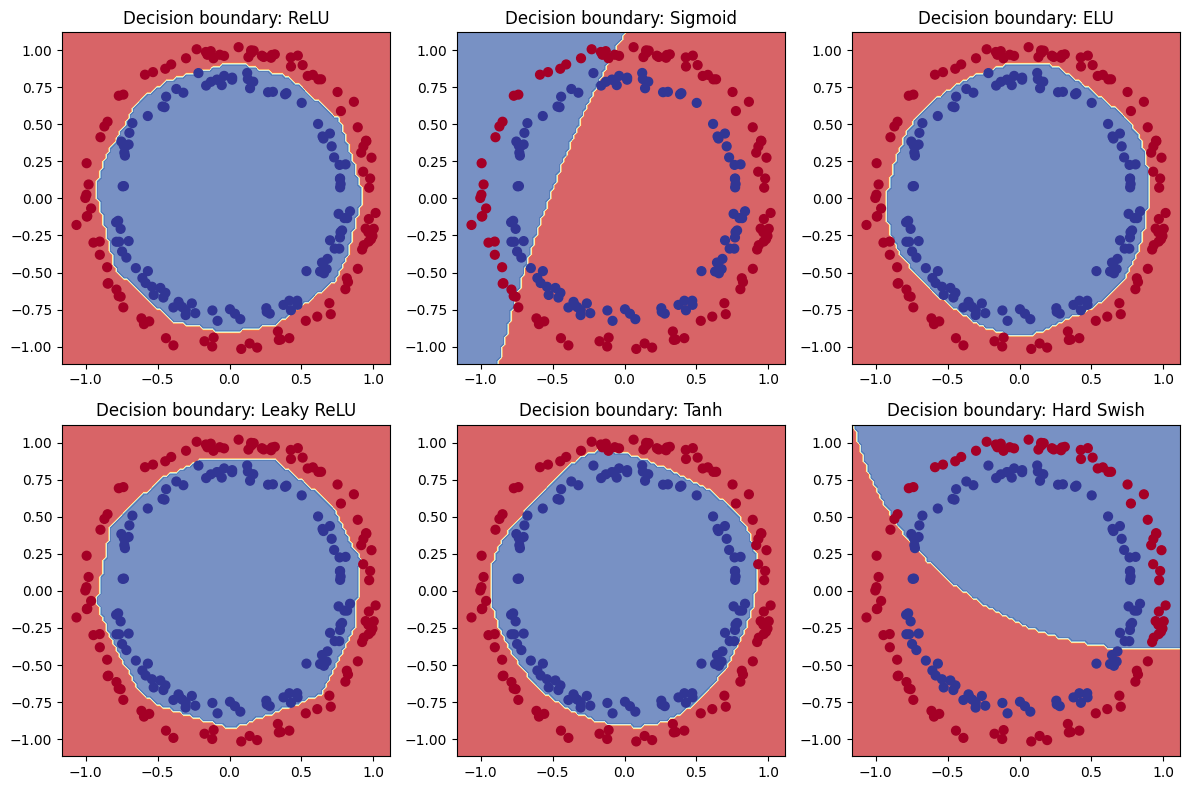

In [54]:
# Plot decision boundaries
fig, axs = plt.subplots(2, 3, figsize=(12,8))
for i, name in enumerate(models.keys()):
  plot_decision_boundary(models[name], X_test, y_test, axs[i%2][i//2],
                         name)
fig.tight_layout()

In my experiments, the Sigmoid model completely failed to learn the data. The Hard Swish function had also not finished learning after 2000 epochs. The other models did quite well. We can see more detail by plotting the loss and accuracy curves:

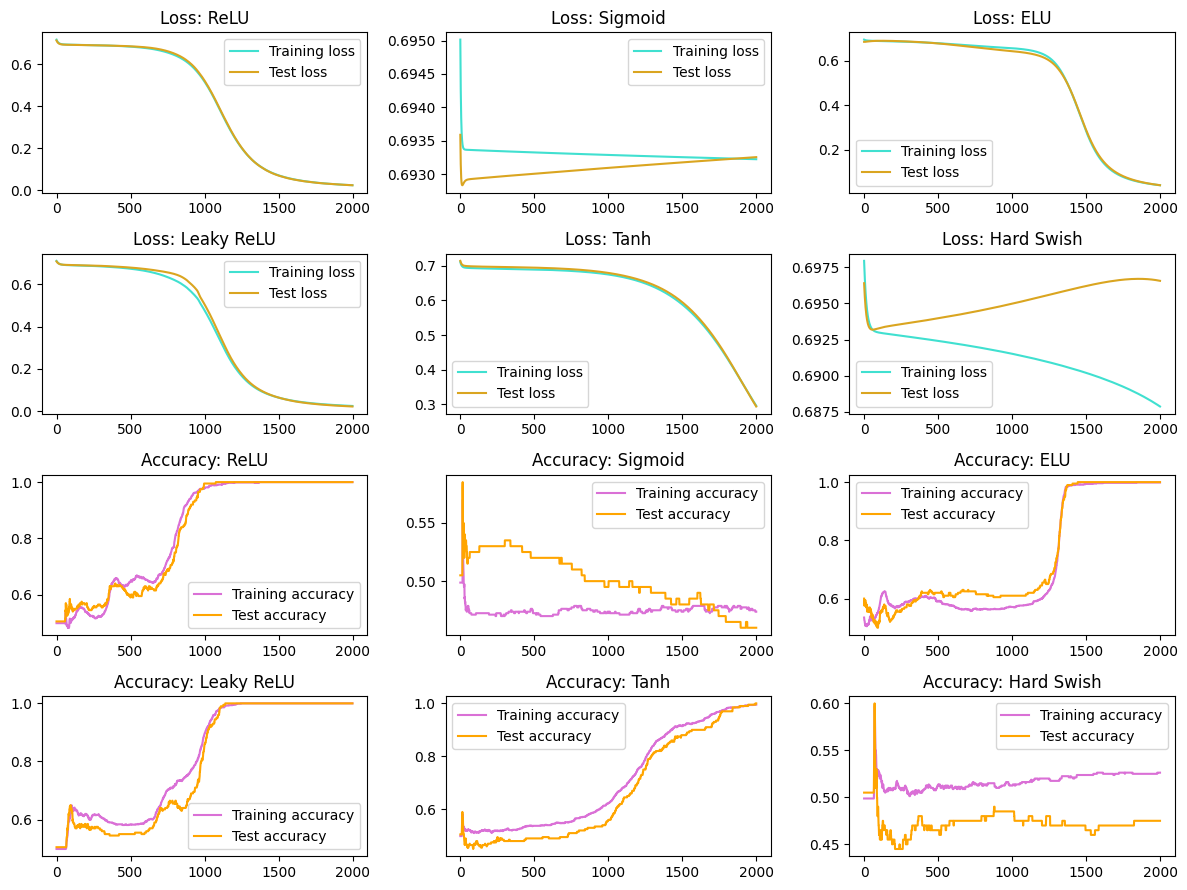

In [56]:
# Plot loss and accuracy over time
fig, axs = plt.subplots(4, 3, figsize=(12, 9))
for i, name in enumerate(models.keys()):
  axes_to_use = [axs[0 + i%2][i//2], axs[2 + i%2][i//2]]
  plot_loss_and_acc(hist_dict[name], axes_to_use, name)
fig.tight_layout()

My observations from this are:
- ReLU, Leaky ReLU, and ELU show similar behavior (maybe expected, as these functions have a broadly similar shape.
- Of these, ReLU converges fastest, beginning to converge around 800 epochs and finishing by about 1100, while ELU converges quickly between 1000 and 1200 epochs. Leaky ReLU converges slower and more smoothly.
- Tanh converged very slowly between 1000 and 2000 epochs, but had achieved near-perfect accuracy by 2000 epochs.
- Hard Swish had a very slow convergence, which was beginning to pick up by 2000 epochs. Note that for most of the training period, the test accuracy was actually decreasing, and the test loss increasing.
- Sigmoid had essentially stabilized at 50% accuracy for the entire training period. This is really undesirable.

A crude way to see what's going on is to view the gradient used to update each model in the last training step. We ignore the gradient components with respect to biases, which in some sense are measured in different units than those with respect to weights.

Activation function: ReLU	| Number of zero gradients: 55	| Largest magnitude gradient: 9.6782e-03	| Smallest magnitude gradient: 0.0000e+00
Activation function: Leaky ReLU	| Number of zero gradients: 0	| Largest magnitude gradient: 6.3409e-03	| Smallest magnitude gradient: 1.3293e-10
Activation function: Sigmoid	| Number of zero gradients: 0	| Largest magnitude gradient: 2.2448e-04	| Smallest magnitude gradient: 2.6980e-07
Activation function: Tanh	| Number of zero gradients: 0	| Largest magnitude gradient: 2.7569e-02	| Smallest magnitude gradient: 1.4742e-05
Activation function: ELU	| Number of zero gradients: 0	| Largest magnitude gradient: 9.1508e-03	| Smallest magnitude gradient: 6.3887e-06
Activation function: Hard Swish	| Number of zero gradients: 0	| Largest magnitude gradient: 2.9484e-03	| Smallest magnitude gradient: 9.9640e-07


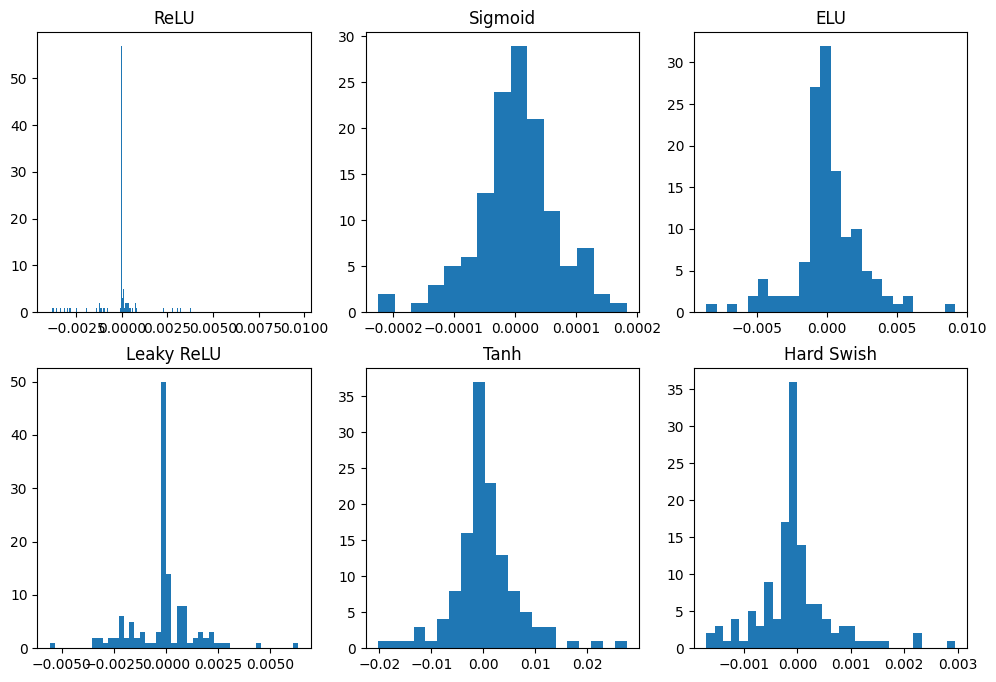

In [74]:
fig, axs = plt.subplots(2, 3, figsize=(12,8))
for i, name in enumerate(models.keys()):
  grads = np.hstack([params.grad.data.view(-1).cpu().clone().numpy()
                     for name, params in models[name].named_parameters()
                     if "weight" in name])
  axs[i%2][i//2].hist(grads, bins='auto')
  axs[i%2][i//2].set_title(name)
  print(f"Activation function: {name}\t| "
        f"Number of zero gradients: {len(grads) - np.count_nonzero(grads)}\t| "
        f"Largest magnitude gradient: {np.abs(grads).max():.4e}\t| "
        f"Smallest magnitude gradient: {np.abs(grads).min():.4e}")

The gradients applied to the Sigmoid model are an order of magnitude smaller than those of any other model. The model is simply not learning fast enough. Note that the sigmoid function itself has a fairly small derivative -- bounded by $1/4$, and close to 0 for large and small values of the input.

The other phenomenon worth remarking on is that 55 of the 130 gradient components for the ReLU model are zero. Since the ReLU activation function has derivative 0 for negative inputs, it's very possible for a unit using this activation function to end up "trapped" in this negative region and no longer update. The ReLU model was still very capable of fitting our (extremely simple) dataset.